In [1]:
import os
import zipfile
import cv2
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torchvision.models as models
import timm

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import copy
import time

import random
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
labels_csv_path = "/kaggle/input/unified-dataset/labels.csv"
labels_df = pd.read_csv(labels_csv_path)

In [3]:
def apply_clahe(img, **kwargs):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    merged = cv2.merge((cl,a,b))
    final = cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)

    return final

In [4]:
def get_transforms(train=True):
    if train:
        return A.Compose([
            A.Lambda(image=apply_clahe),
            A.Resize(224, 224),
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.5),
            A.Rotate(limit=15, p=0.5),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ])
    else:
        return A.Compose([
            A.Lambda(image=apply_clahe),
            A.Resize(224, 224),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ])

In [5]:
class GlaucomaDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.df.loc[idx, 'image_path'])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.df.loc[idx, 'label']

        if self.transform:
            image = self.transform(image=image)['image']

        return image, label, img_path

In [6]:
train_df, val_df = train_test_split(labels_df, test_size=0.2, stratify=labels_df['label'], random_state=42)

In [7]:
train_dataset = GlaucomaDataset(train_df, root_dir="/kaggle/input/unified-dataset", transform=get_transforms(train=True))
val_dataset = GlaucomaDataset(val_df, root_dir="/kaggle/input/unified-dataset", transform=get_transforms(train=False))

In [8]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)

In [9]:
dataloaders = {'train': train_loader, 'val': val_loader}

In [10]:
print("Preprocessing Done.")

Preprocessing Done.


---

---

In [11]:
def get_vit_base_patch16_224(pretrained=True, num_classes=2):
    model = timm.create_model('vit_base_patch16_224', pretrained=pretrained)
    model.head = nn.Linear(model.head.in_features, num_classes)

    return model

In [26]:
def get_swin_base_patch4_window7_224(pretrained=True, num_classes=2):
    model = timm.create_model('swin_base_patch4_window7_224', pretrained=pretrained, num_classes=num_classes)
    return model

In [13]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, device,
                num_epochs=25, early_stopping_patience=5, model_name="model"):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1 = 0.0
    epochs_no_improve = 0

    history = {key: [] for key in [
        'train_loss', 'val_loss', 'train_acc', 'val_acc', 'train_prec', 'val_prec',
        'train_rec', 'val_rec', 'train_f1', 'val_f1', 'train_auc', 'val_auc']}

    all_preds = {'train': {}, 'val': {}}

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print('-' * 20)

        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()

            running_loss = 0.0
            all_labels = []
            all_logits = []

            for inputs, labels, _ in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                all_labels.append(labels.cpu().numpy())
                all_logits.append(outputs.detach().cpu().numpy())

            # After full epoch:
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            all_labels = np.concatenate(all_labels)
            all_logits = np.concatenate(all_logits)

            probs = torch.softmax(torch.from_numpy(all_logits), dim=1).numpy()
            preds = np.argmax(probs, axis=1)

            acc = accuracy_score(all_labels, preds)
            prec = precision_score(all_labels, preds, zero_division=0)
            rec = recall_score(all_labels, preds, zero_division=0)
            f1 = f1_score(all_labels, preds, zero_division=0)
            try:
                auc = roc_auc_score(all_labels, probs[:, 1])
            except Exception:
                auc = 0.0

            # Save metrics
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(acc)
            history[f'{phase}_prec'].append(prec)
            history[f'{phase}_rec'].append(rec)
            history[f'{phase}_f1'].append(f1)
            history[f'{phase}_auc'].append(auc)

            all_preds[phase]['y_true'] = all_labels
            all_preds[phase]['y_pred'] = preds

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {acc:.4f} Prec: {prec:.4f} Rec: {rec:.4f} F1: {f1:.4f} AUC: {auc:.4f}")

            if phase == 'val':
                if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                    scheduler.step(epoch_loss)
                else:
                    scheduler.step()

                if f1 > best_f1:
                    best_f1 = f1
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(best_model_wts, f'{model_name}_best.pth')
                    print(f"--> Best model saved with val F1: {best_f1:.4f}")
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1

        if epochs_no_improve >= early_stopping_patience:
            print(f"Early stopping triggered after {epoch+1} epochs with no improvement.")
            break

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best val F1: {best_f1:.4f}")

    model.load_state_dict(best_model_wts)

    return model, history, all_preds

In [14]:
def plot_metrics_single_model(history, model_name):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(16, 10))

    # Loss
    plt.subplot(2, 3, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy
    plt.subplot(2, 3, 2)
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['val_acc'], label='Val Acc')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Precision
    plt.subplot(2, 3, 3)
    plt.plot(epochs, history['train_prec'], label='Train Precision')
    plt.plot(epochs, history['val_prec'], label='Val Precision')
    plt.title(f'{model_name} Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.legend()

    # Recall
    plt.subplot(2, 3, 4)
    plt.plot(epochs, history['train_rec'], label='Train Recall')
    plt.plot(epochs, history['val_rec'], label='Val Recall')
    plt.title(f'{model_name} Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend()

    # F1-score
    plt.subplot(2, 3, 5)
    plt.plot(epochs, history['train_f1'], label='Train F1')
    plt.plot(epochs, history['val_f1'], label='Val F1')
    plt.title(f'{model_name} F1-score')
    plt.xlabel('Epoch')
    plt.ylabel('F1-score')
    plt.legend()

    # AUC
    plt.subplot(2, 3, 6)
    plt.plot(epochs, history['train_auc'], label='Train AUC')
    plt.plot(epochs, history['val_auc'], label='Val AUC')
    plt.title(f'{model_name} ROC AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [15]:
def plot_metrics_for_publication(history, model_name, save_path=None):
    epochs = range(1, len(history['train_loss']) + 1)
    metrics = ['loss', 'acc', 'prec', 'rec', 'f1', 'auc']
    titles = ['Loss', 'Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC AUC']

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    for i, metric in enumerate(metrics):
        axes[i].plot(epochs, history[f'train_{metric}'], label='Train', linewidth=2)
        axes[i].plot(epochs, history[f'val_{metric}'], label='Validation', linewidth=2)
        axes[i].set_title(f'{titles[i]}', fontsize=14)
        axes[i].set_xlabel('Epoch', fontsize=12)
        axes[i].set_ylabel(titles[i], fontsize=12)
        axes[i].legend()
        axes[i].grid(True)

    plt.suptitle(f'{model_name.upper()} Performance Metrics', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

In [16]:
def print_final_metrics_for_report(history):
    final_epoch = len(history['train_loss']) - 1
    metrics = ['loss', 'acc', 'prec', 'rec', 'f1', 'auc']
    print(f"{'Metric':<10} | {'Train':>10} | {'Validation':>10}")
    print("-" * 36)
    for metric in metrics:
        train_val = history[f'train_{metric}'][final_epoch]
        val_val = history[f'val_{metric}'][final_epoch]
        print(f"{metric.capitalize():<10} | {train_val:10.4f} | {val_val:10.4f}")

In [17]:
def save_metrics_to_csv(history, filename="final_metrics.csv"):
    final_epoch = len(history['train_loss']) - 1
    data = {
        'Metric': [],
        'Train': [],
        'Validation': []
    }
    for metric in ['loss', 'acc', 'prec', 'rec', 'f1', 'auc']:
        data['Metric'].append(metric)
        data['Train'].append(history[f'train_{metric}'][final_epoch])
        data['Validation'].append(history[f'val_{metric}'][final_epoch])
    
    df = pd.DataFrame(data)
    df.to_csv(filename, index=False)
    print(f"Metrics saved to {filename}")

In [18]:
def plot_confusion_matrix_single_model(y_true, y_pred, model_name):
    disp = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, cmap='Blues', normalize='true')
    disp.ax_.set_title(f'{model_name} Normalized Confusion Matrix')
    plt.show()

In [19]:
def attention_rollout(model, input_tensor, device, discard_ratio=0.9):
    model.eval()
    input_tensor = input_tensor.to(device)

    with torch.no_grad():
        attentions = []

        def get_attention(module, input, output):
            attentions.append(output)

        handles = []
        if hasattr(model, 'blocks'):
            for block in model.blocks:
                handles.append(block.attn.register_forward_hook(get_attention))
        elif hasattr(model, 'layers'):
            for layer in model.layers:
                for block in layer.blocks:
                    handles.append(block.attn.register_forward_hook(get_attention))
        else:
            print("Attention rollout: Unknown model architecture.")
            return None

        _ = model(input_tensor)

        for h in handles:
            h.remove()

        if len(attentions) == 0:
            print("Attention rollout: No attentions captured.")
            return None

        att_mat = [att[0].mean(0).cpu().numpy() for att in attentions]

        att_mat = [att + np.eye(att.shape[0]) for att in att_mat]

        att_mat = [att / att.sum(axis=1, keepdims=True) for att in att_mat]

        rollout = att_mat[0]
        for i in range(1, len(att_mat)):
            rollout = rollout @ att_mat[i]

        mask = rollout[0, 1:]

        size = int(np.sqrt(mask.shape[0]))
        mask = mask.reshape(size, size)

        mask = cv2.resize(mask, (input_tensor.size(3), input_tensor.size(2)))
        mask = mask - mask.min()
        mask = mask / (mask.max() + 1e-8)

        threshold = np.quantile(mask, discard_ratio)
        mask[mask < threshold] = 0

        return mask

In [20]:
def explain_random_image(model, dataset, device, model_name):
    model.eval()
    idx = random.randint(0, len(dataset) - 1)
    img_tensor, label, img_path = dataset[idx]
    input_tensor = img_tensor.unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(input_tensor)
        pred = output.argmax(dim=1).item()
    print(f"Random Image: {img_path}\nGround Truth: {label}\nPredicted: {pred}")

    if model_name in ['resnet50', 'efficientnet_b0', 'densenet121']:
        cam = generate_gradcam(model, img_tensor, pred, device, model_name)
        if cam is not None:
            show_gradcam_on_image(img_tensor, cam, title=f"Grad-CAM for {model_name}")
    elif model_name in ['vit_base_patch16_224', 'swin_base_patch4_window7_224']:
        mask = attention_rollout(model, input_tensor, device)
        if mask is not None:
            img = img_tensor.permute(1, 2, 0).cpu().numpy()
            mean = np.array([0.485, 0.456, 0.406])
            std  = np.array([0.229, 0.224, 0.225])
            img = std * img + mean
            img = np.clip(img, 0, 1)

            heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
            heatmap = np.float32(heatmap) / 255
            overlay = heatmap + img
            overlay = overlay / np.max(overlay)

            plt.figure(figsize=(6, 6))
            plt.imshow(overlay)
            plt.axis('off')
            plt.title(f"Attention Rollout for {model_name}")
            plt.show()
        else:
            print(f"Attention rollout explanation not available for {model_name}.")
    else:
        print(f"Explanation not implemented for {model_name}.")

In [27]:
def run_model(model_name):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    model_getters = {
        # 'resnet50': get_resnet50,
        # 'efficientnet_b0': get_efficientnet_b0,
        # 'densenet121': get_densenet121,
        'vit_base_patch16_224': get_vit_base_patch16_224,
        'swin_base_patch4_window7_224': get_swin_base_patch4_window7_224
    }

    if model_name not in model_getters:
        raise ValueError(f"Unknown model_name {model_name}")

    model = model_getters[model_name](pretrained=True, num_classes=2).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3)

    criterion = nn.CrossEntropyLoss()

    model, history, all_preds = train_model(
        model, dataloaders, criterion, optimizer, scheduler,
        device=device, num_epochs=25, early_stopping_patience=5,
        model_name=model_name
    )

    plot_metrics_for_publication(history, model_name=model_name, save_path=f"{model_name}_metrics.pdf")

    print("\n===== Final Metrics for Publication =====")
    print_final_metrics_for_report(history)

    save_metrics_to_csv(history, filename=f"{model_name}_final_metrics.csv")

    plot_confusion_matrix_single_model(all_preds['val']['y_true'], all_preds['val']['y_pred'], model_name)

    # explain_random_image(model, val_dataset, device, model_name)

    return model, history, all_preds

Using device: cuda


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Epoch 1/25
--------------------
train Loss: 0.5054 Acc: 0.7538 Prec: 0.7444 Rec: 0.7261 F1: 0.7352 AUC: 0.8365
val Loss: 0.3517 Acc: 0.8467 Prec: 0.8320 Rec: 0.8450 F1: 0.8384 AUC: 0.9246
--> Best model saved with val F1: 0.8384
Epoch 2/25
--------------------
train Loss: 0.3950 Acc: 0.8265 Prec: 0.8196 Rec: 0.8096 F1: 0.8146 AUC: 0.9030
val Loss: 0.3541 Acc: 0.8497 Prec: 0.7940 Rec: 0.9193 F1: 0.8520 AUC: 0.9359
--> Best model saved with val F1: 0.8520
Epoch 3/25
--------------------
train Loss: 0.3644 Acc: 0.8414 Prec: 0.8333 Rec: 0.8289 F1: 0.8311 AUC: 0.9179
val Loss: 0.3689 Acc: 0.8333 Prec: 0.7651 Rec: 0.9321 F1: 0.8404 AUC: 0.9387
Epoch 4/25
--------------------
train Loss: 0.3483 Acc: 0.8528 Prec: 0.8447 Rec: 0.8420 F1: 0.8433 AUC: 0.9254
val Loss: 0.3403 Acc: 0.8463 Prec: 0.8069 Rec: 0.8853 F1: 0.8443 AUC: 0.9323
Epoch 5/25
--------------------
train Loss: 0.3360 Acc: 0.8584 Prec: 0.8465 Rec: 0.8539 F1: 0.8502 AUC: 0.9306
val Loss: 0.3560 Acc: 0.8441 Prec: 0.9283 Rec: 0.7248 F

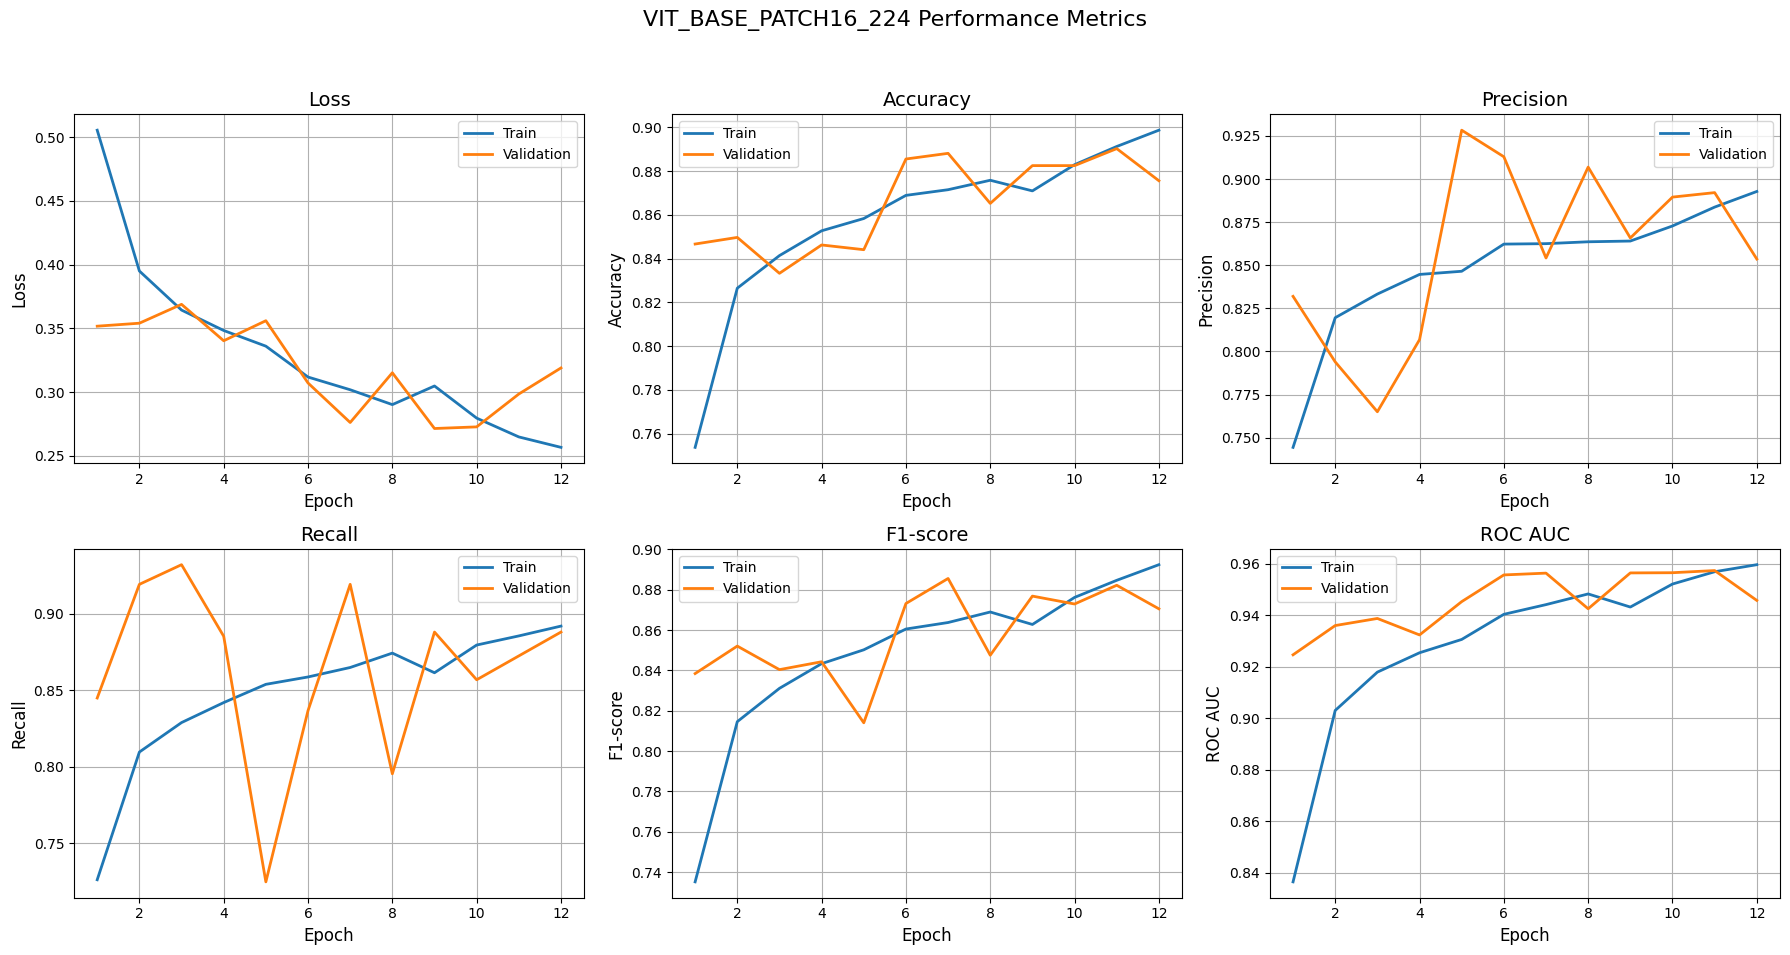


===== Final Metrics for Publication =====
Metric     |      Train | Validation
------------------------------------
Loss       |     0.2567 |     0.3190
Acc        |     0.8987 |     0.8756
Prec       |     0.8928 |     0.8536
Rec        |     0.8920 |     0.8881
F1         |     0.8924 |     0.8705
Auc        |     0.9596 |     0.9457
Metrics saved to vit_base_patch16_224_final_metrics.csv


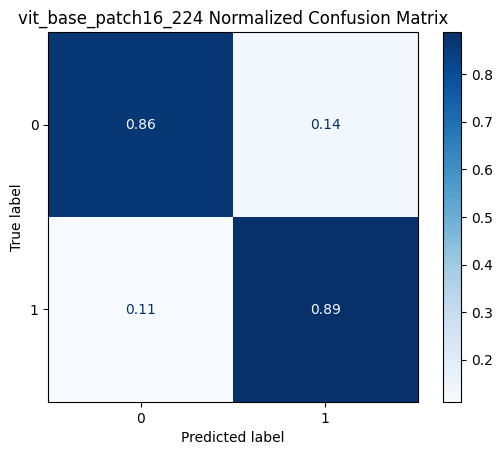

In [24]:
model_vit, history_vit, preds_vit = run_model('vit_base_patch16_224')

Using device: cuda
Epoch 1/25
--------------------
train Loss: 0.5989 Acc: 0.6635 Prec: 0.6502 Rec: 0.6170 F1: 0.6332 AUC: 0.7370
val Loss: 0.4164 Acc: 0.8191 Prec: 0.9241 Rec: 0.6706 F1: 0.7772 AUC: 0.9387
--> Best model saved with val F1: 0.7772
Epoch 2/25
--------------------
train Loss: 0.3423 Acc: 0.8591 Prec: 0.8440 Rec: 0.8596 F1: 0.8517 AUC: 0.9275
val Loss: 0.2533 Acc: 0.9033 Prec: 0.8733 Rec: 0.9294 F1: 0.9004 AUC: 0.9671
--> Best model saved with val F1: 0.9004
Epoch 3/25
--------------------
train Loss: 0.2769 Acc: 0.8922 Prec: 0.8838 Rec: 0.8876 F1: 0.8857 AUC: 0.9522
val Loss: 0.2201 Acc: 0.9132 Prec: 0.8783 Rec: 0.9468 F1: 0.9113 AUC: 0.9722
--> Best model saved with val F1: 0.9113
Epoch 4/25
--------------------
train Loss: 0.2557 Acc: 0.9004 Prec: 0.8896 Rec: 0.9000 F1: 0.8948 AUC: 0.9590
val Loss: 0.2223 Acc: 0.9167 Prec: 0.8850 Rec: 0.9459 F1: 0.9144 AUC: 0.9738
--> Best model saved with val F1: 0.9144
Epoch 5/25
--------------------
train Loss: 0.2210 Acc: 0.9144 Pr

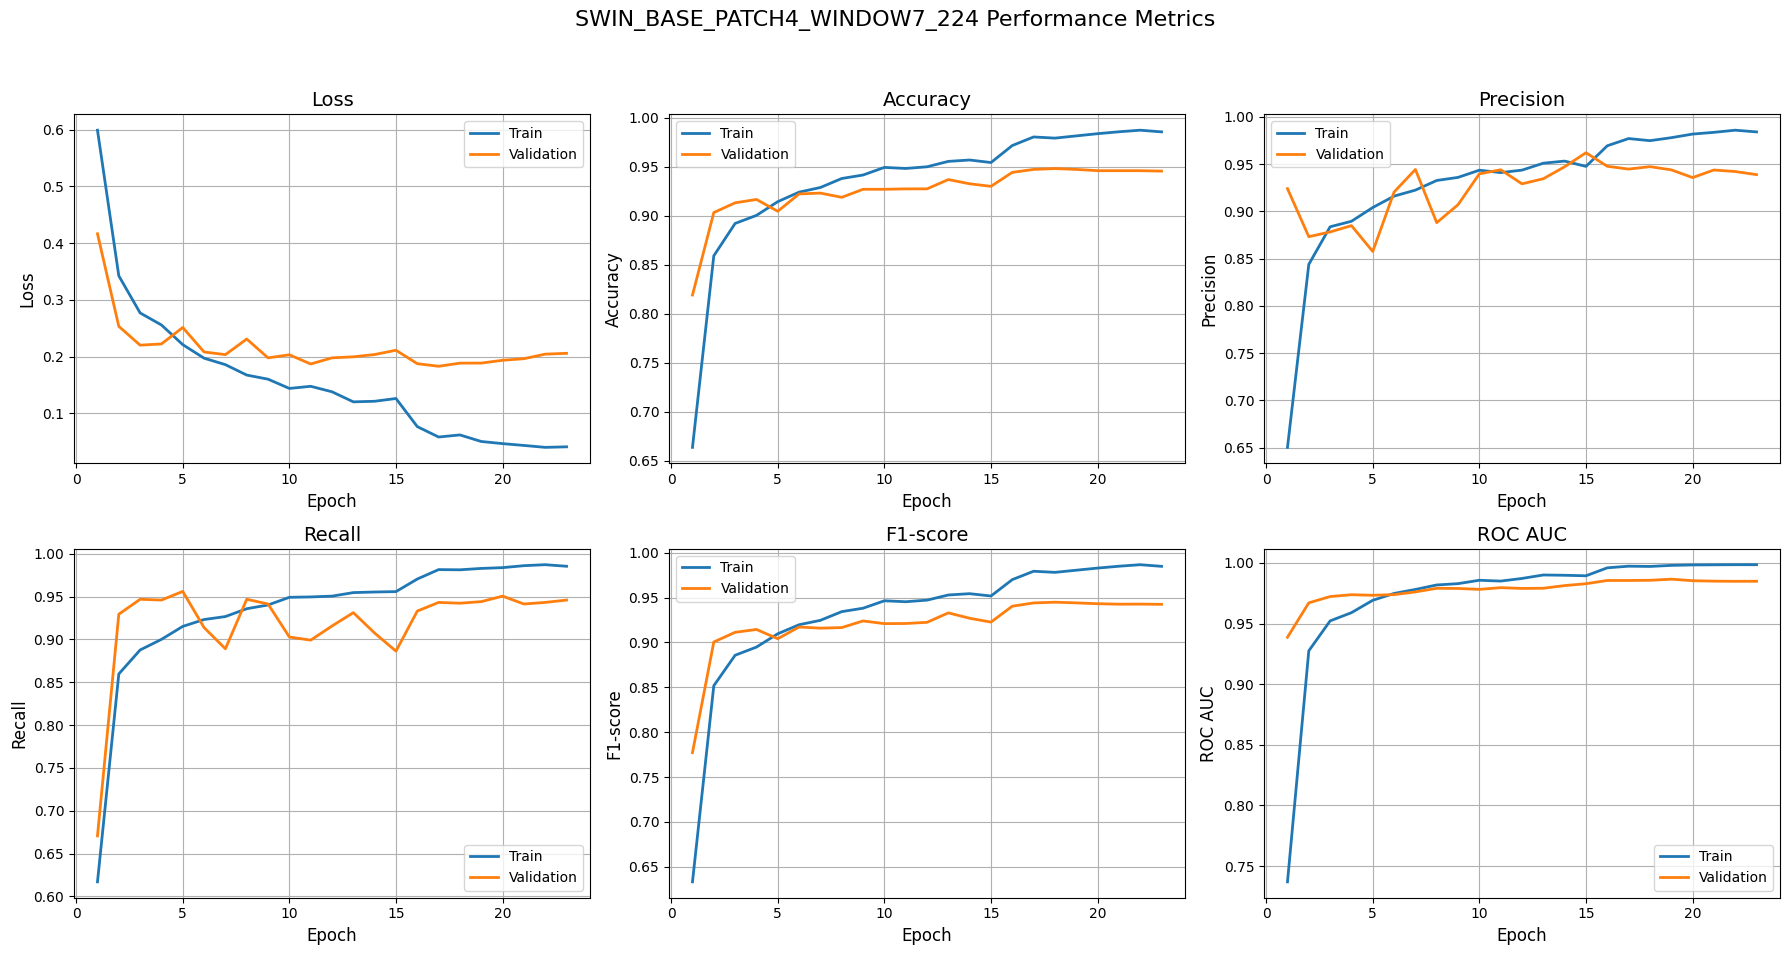


===== Final Metrics for Publication =====
Metric     |      Train | Validation
------------------------------------
Loss       |     0.0410 |     0.2057
Acc        |     0.9856 |     0.9456
Prec       |     0.9842 |     0.9390
Rec        |     0.9853 |     0.9459
F1         |     0.9848 |     0.9424
Auc        |     0.9985 |     0.9849
Metrics saved to swin_base_patch4_window7_224_final_metrics.csv


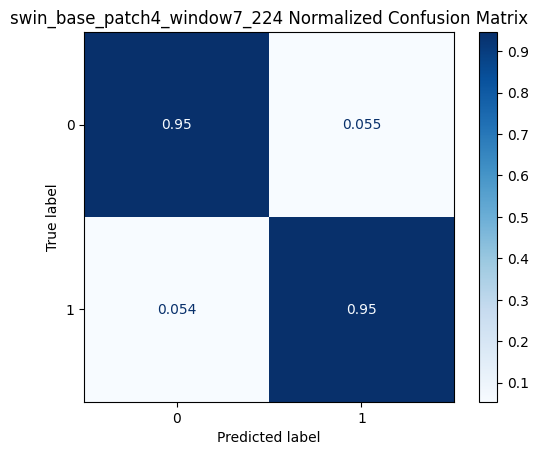

In [28]:
model_swin, history_swin, preds_swin = run_model('swin_base_patch4_window7_224')